## Generating map plot to support description of elevation downscaling
Follow `example_map_panels.py` and combine the anomaly plots with lapse-rate plots

EDITS:
- 24 Aug 2023: Plot simplified figure with just two months of map view and lapse rate together, as suggested by a reviewer.  Also allow flexible order of best fit per catchment.  

## Map plot
Read in Kangerlussuaq catchment outline, compute catchment mean, extract point values, and compute anomalies

In [67]:
from shapely.geometry import MultiPoint, Polygon, Point
from shapely.ops import triangulate
from scipy.spatial import distance
import shapefile
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import pyproj as pyproj
from scipy import interpolate
import datetime
import time
import matplotlib.pyplot as plt
from matplotlib import cm
from stochSMB import segments_fit

In [68]:
## Where is the data?
SMBMIP_paths = ['/Users/lizz/Documents/GitHub/Data_unsynced/SMBMIP/',
                '/Volumes/Backup Plus/Large data moved 20220331/SMBMIP/',
                '/Volumes/GoogleDrive/My Drive/Greenland-data/SMBMIP/'
               ] ## all the options used thus far

smb_path = SMBMIP_paths[2] ##current one

In [69]:
###------------------------
### CHOOSE CATCHMENTS
###------------------------
catchments_to_pull = (101,)

###------------------------
### DATA READ-IN  AND PROJECTION
###------------------------

## Read in BedMachine grid to reproject SMB
gl_bed_path ='/Users/lizz/Documents/GitHub/Data_unsynced/BedMachine-Greenland/BedMachineGreenland-2017-09-20.nc'
fh = Dataset(gl_bed_path, mode='r')
xx = fh.variables['x'][:].copy() # x-coord (polar stereo (70, 45))
yy = fh.variables['y'][:].copy() # y-coord
ss = fh.variables['surface'][:].copy() # surface elevation
fh.close()

## Read in Mouginot catchments from shapefile
print('Reading in Mouginot catchments')
catchment_fn = '/Users/lizz/Documents/GitHub/Data_unsynced/Greenland-catchments-Mouginot/Greenland_Basins_PS_v1.4.2.'
sf = shapefile.Reader(catchment_fn) 

## Example SMB field read in for grid
print('Reading in example SMB field')
nhm_smb_path = smb_path+'NHM-SMAP_niwano-monthly-ERA-Interim-1980.nc'
fh2 = Dataset(nhm_smb_path, mode='r')
xlon_nhm = fh2.variables['LON'][:].copy() #x-coord (latlon)
ylat_nhm = fh2.variables['LAT'][:].copy() #y-coord (latlon)
fh2.close()

###------------------------
### SET UP SMB REPROJECTION
###------------------------

## Down-sample bed topo
x_3km = xx[::20] # sample at ~3 km resolution
y_3km = yy[::20]
s_3km = ss[::20,::20]

## Down-sample SMB
x_lon_h = xlon_nhm[::10, ::10] 
y_lat_h = ylat_nhm[::10, ::10] # resolution about 10 km

print('Creating reprojected meshgrid')
wgs84 = pyproj.Proj("+init=EPSG:4326") # LatLon with WGS84 datum used by SMB data
psn_gl = pyproj.Proj("+init=epsg:3413") # Polar Stereographic North used by BedMachine and Mankoff
xs, ys = pyproj.transform(wgs84, psn_gl, x_lon_h, y_lat_h)
Xmat, Ymat = np.meshgrid(x_3km, y_3km) # Downsampled BedMachine coords

Reading in Mouginot catchments
Reading in example SMB field
Creating reprojected meshgrid


/opt/anaconda3/envs/stisp-unfucked/lib/python3.10/site-packages/pyproj/crs/crs.py:292: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/opt/anaconda3/envs/stisp-unfucked/lib/python3.10/site-packages/pyproj/crs/crs.py:292: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/var/folders/1w/5s0157gx20d0jd0hrtvmpmh40000gp/T/ipykernel_83383/3639201912.py:47: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-

In [70]:
##------------------------
## CREATE FRAMEWORK
##------------------------

## Identify grid points within catchment
pts_all = [(xs.ravel()[k], ys.ravel()[k]) for k in range(len(xs.ravel()))]
pt_ctmts = {i: [] for i in catchments_to_pull}
for i in catchments_to_pull:
    print('Point-checking catchment {}'.format(sf.record(i)['NAME']))
    c = Polygon(sf.shape(i).points)
    pts_in = [Point(p).within(c) for p in pts_all]
    pts = np.asarray(pts_all)[pts_in]
    pt_ctmts[i] = pts

Point-checking catchment KANGERLUSSUAQ


In [71]:
## Create data frames to store per-model data
# model_names = ['ANICE-ITM_Berends', 'CESM_kampenhout', 'dEBM_krebs','HIRHAM_mottram', 
#                 'NHM-SMAP_niwano', 'RACMO_noel', 'SNOWMODEL_liston']
# model_names = ['ANICE-ITM_Berends',]
model_names=['RACMO_noel',]
years = range(1980,1985)
start_date = datetime.datetime(years[0],1,1)
end_date = datetime.datetime(years[-1],12,31)
dates = pd.date_range(start=start_date, end=end_date, freq='M')
example_df_per_ctchmnt = {i: 
                  {m: 
                   {n: 
                    {y: pd.DataFrame(columns=('elevation', 
                                                'point_smb'))  for y in years}
                    for n in range(12)}
                     for m in model_names}
                      for i in catchments_to_pull}

In [72]:
###------------------------
### EXTRACT EXAMPLE SMB FIELD FOR CATCHMENT
###------------------------

## Store regridded SMBs for use in each catchment to take all available data
smb_ex_monthly = {i: [] for i in range(12)}

for m in model_names:
    t0 = time.time()
    if m=='CESM_kampenhout':
        vname = 'SMBCORR'
    else:
        vname = 'SMBcorr'
    for y in years:
        ti = time.time()
        fpath = smb_path+'{}-monthly-ERA-Interim-{}.nc'.format(m, y)
        fh = Dataset(fpath, mode='r')
        smb_m = fh.variables[vname][:].copy()
        fh.close()
        d_subset = [d for d in dates if d.year==y]
        for i in range(len(smb_m)): # for each month
            ## downsample SMB
            smb_ds = smb_m[i][::10, ::10]
            ## Sample SMB at each Delaunay triangle and sum
            for j in catchments_to_pull:
                points = pt_ctmts[j]
                elevations = []
                smb_point_vals = smb_ds.ravel()[pts_in] ## go back and revise this to use new pts_in for every catchment
                for p in points:
                    surf_x = (np.abs(x_3km - p[0])).argmin()
                    surf_y = (np.abs(y_3km - p[1])).argmin()
                    elevations.append(s_3km[surf_y, surf_x])
                example_df_per_ctchmnt[j][m][i][y] = example_df_per_ctchmnt[j][m][i][y].assign(elevation=elevations,
                                            point_smb=smb_point_vals)
                
        tf = time.time()
        print('Finished processing year {} in time {}s'.format(y, tf-ti))
    t1 = time.time()
    print('Finished processing model {} in time {}'.format(m, t1-t0))

Finished processing year 1980 in time 4.677680730819702s
Finished processing year 1981 in time 4.168874025344849s
Finished processing year 1982 in time 4.153443813323975s
Finished processing year 1983 in time 5.0732741355896s
Finished processing year 1984 in time 4.009032964706421s
Finished processing model RACMO_noel in time 22.08265995979309


## Monthly anomaly plot

In [ ]:
fig, axs = plt.subplots(3,4, sharex=True, sharey=True)
for i in range(12):
    ax=axs.ravel()[i]
    example_smb = example_df_per_ctchmnt[101]['ANICE-ITM_Berends'][i][1980]['point_smb']
    sc = ax.scatter(0.001*pt_ctmts[101][:,0], 0.001*pt_ctmts[101][:,1], 
               c=example_smb - np.mean(example_smb),
               vmin=-500, vmax=500,
               cmap='RdBu')
    ax.set(aspect=1)
    if (i+1)%4==0:
        cb = fig.colorbar(sc, ax=ax)
        # cb.ax.set_title('SMB anomaly')
    else:
        continue  
plt.show()


## Lapse rate regression

In [73]:
# df_c = example_df_per_ctchmnt[101]['ANICE-ITM_Berends']
df_c = example_df_per_ctchmnt[101]['RACMO_noel']

dict_per_month = {i: [] for i in range(12)}
for i in range(12):
    d_to_join = [df_c[i][y] for y in years]
    dict_per_month[i] = pd.concat(d_to_join)

c = cm.get_cmap('tab20b')

/var/folders/1w/5s0157gx20d0jd0hrtvmpmh40000gp/T/ipykernel_83383/660735915.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  c = cm.get_cmap('tab20b')


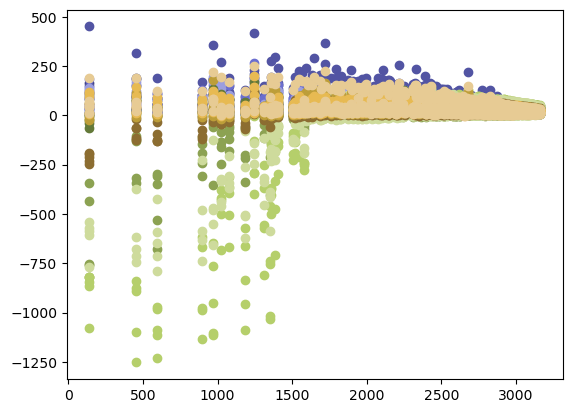

In [74]:
plt.figure()
for i in range(12):
    df = dict_per_month[i]
    # f = interpolate.splrep(df['elevation'], df['point_smb'])
    # plt.scatter(df['elevation'], df['point_smb'], color=c(i), label='Month '+d_subset[i].strftime('%m'))
    plt.scatter(df['elevation'], df['point_smb'], color=c(i%12), label=dates[i].strftime('%m/%Y'))
# plt.legend(loc='best')
plt.show()

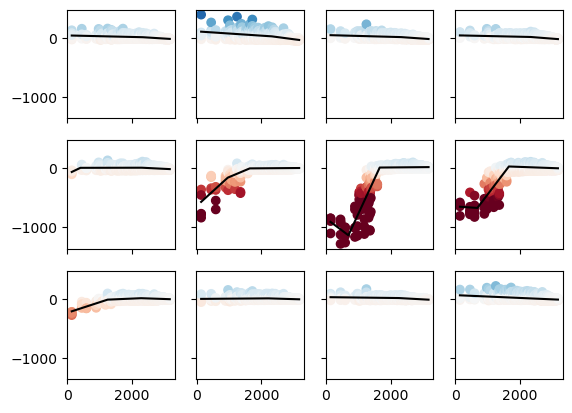

In [75]:
# ## Make a piecewise linear fit and plot it
# ## Color this plot like the map plot

monthly_mbg = {i: [] for i in range(12)}

fig, axs = plt.subplots(3, 4, sharex=True, sharey=True)
for i in range(12):
    ax = axs.ravel()[i]
    df = dict_per_month[i]
    pt_smbs = np.asarray(df.sort_values(by='elevation')['point_smb'])
    anomalies = pt_smbs - np.mean(pt_smbs)
    ax.scatter(df.sort_values(by='elevation')['elevation'], anomalies, 
               c=anomalies, vmin=-500, vmax=500, cmap='RdBu',
               label=dates[i].strftime('%m/%Y'))

    px, py = segments_fit(np.asarray(df.sort_values(by='elevation')['elevation']),
                          anomalies,
                          maxcount=3)
    monthly_mbg[i] = (px,py)
    ax.plot(px, py, color='k')
#     ax.text(1000,-1100,'Month {}'.format(i+1))
# plt.legend(loc='best')
plt.show()

## Try with insets

In [ ]:
## inset the line plot in accumulation area?

fig, axs = plt.subplots(3,4, sharex=True, sharey=True)
for i in range(12):
    ax=axs.ravel()[i]
    axin1 = ax.inset_axes([0.59, 0.69, 0.4, 0.3])
        
    example_smb = example_df_per_ctchmnt[101]['ANICE-ITM_Berends'][i][1980]['point_smb']
    sc = ax.scatter(0.001*pt_ctmts[101][:,0], 0.001*pt_ctmts[101][:,1], 
               c=example_smb - np.mean(example_smb),
               vmin=-500, vmax=500,
               cmap='RdBu')
    
    df = dict_per_month[i]
    pt_smbs = np.asarray(df.sort_values(by='elevation')['point_smb'])
    anomalies = pt_smbs - np.mean(pt_smbs)
    axin1.scatter(df.sort_values(by='elevation')['elevation'], anomalies, 
               c=anomalies, vmin=-500, vmax=500, cmap='RdBu',
               label=dates[i].strftime('%m/%Y'))

    px, py = segments_fit(np.asarray(df.sort_values(by='elevation')['elevation']),
                          anomalies,
                          maxcount=3)
    monthly_mbg[i] = (px,py)
    axin1.plot(px, py, color='k')
    axin1.set(ylim=(-1000,300))
    if i==0:
        axin1.set(xticks=(0, 2500), xticklabels=('0','2500'),
                 yticks=(-1000, 0), yticklabels=('-1000', '0'))
        axin1.tick_params(axis='both', which='major', labelsize=8, rotation=50)
    else:
        axin1.set(xticks=(0, 2500), xticklabels=(),
                 yticks=(-1000, 0), yticklabels=())
    
    ax.set(aspect=1)
    if (i+1)%4==0:
        cb = fig.colorbar(sc, ax=ax)
        # cb.ax.set_title('SMB anomaly')
    else:
        continue  
    
plt.show()

In [ ]:
## rescale inset plot to be bigger, re-allocate rows/columns
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable ## attempt to control cbar
from mpl_toolkits.axes_grid1 import ImageGrid


n_across=3
n_rows = int(12/n_across)

# fig, axs = plt.subplots(n_rows,n_across, sharex=True, sharey=True,
#                        figsize=(6, 11))
fig1 = plt.figure(figsize=(6,10))
grid = ImageGrid(fig1, 111, # similar to subplot(111)
                 nrows_ncols=(n_rows, n_across),  # creates grid of axes
                 axes_pad=0.2,  # pad between axes in inch.
                 cbar_mode='edge', 
                 cbar_set_cax=True
                 )

for i in range(12):
#     ax=axs.ravel()[i]
    ax = grid[i]
    axin1 = ax.inset_axes([0.59, 0.69, 0.4, 0.3])
        
    example_smb = example_df_per_ctchmnt[101]['ANICE-ITM_Berends'][i][1980]['point_smb']
    sc = ax.scatter(0.001*pt_ctmts[101][:,0], 0.001*pt_ctmts[101][:,1], 
               c=example_smb - np.mean(example_smb),
               vmin=-500, vmax=500,
               cmap='RdBu')
    
    df = dict_per_month[i]
    pt_smbs = np.asarray(df.sort_values(by='elevation')['point_smb'])
    anomalies = pt_smbs - np.mean(pt_smbs)
    axin1.scatter(df.sort_values(by='elevation')['elevation'], anomalies, 
               c=anomalies, vmin=-500, vmax=500, cmap='RdBu',
               label=dates[i].strftime('%m/%Y'))

    px, py = segments_fit(np.asarray(df.sort_values(by='elevation')['elevation']),
                          anomalies,
                          maxcount=3)
    monthly_mbg[i] = (px,py)
    axin1.plot(px, py, color='k')
    axin1.set(ylim=(-1000,300))
    if i==0:
        axin1.set(xticks=(0, 2500), xticklabels=('0',r'2500' 
                                                 '\n' 
                                                 'm a.s.l.'),
                 yticks=(-1000, 0), yticklabels=(r'-1000'
                                                 '\n'
                                                 'mm w.e.', '0'))
        axin1.tick_params(axis='both', which='major', labelsize=8, rotation=50)
    else:
        axin1.set(xticks=(0, 2500), xticklabels=(),
                 yticks=(-1000, 0), yticklabels=())
    
#     ax.set(aspect=1)
    if (i+1)%n_across==0:
#         div = make_axes_locatable(ax)
#         cax = div.append_axes("right", size="5%", pad=0.1)
        cb = fig.colorbar(sc, cax=ax.cax, ticks=(-500,0,500))
        # cb.ax.set_title('SMB anomaly')
    else:
        continue  

# plt.tight_layout()
plt.show()

## Simplified: side by side
Plot just January and July, in map form on one side and lapse rate on the other.

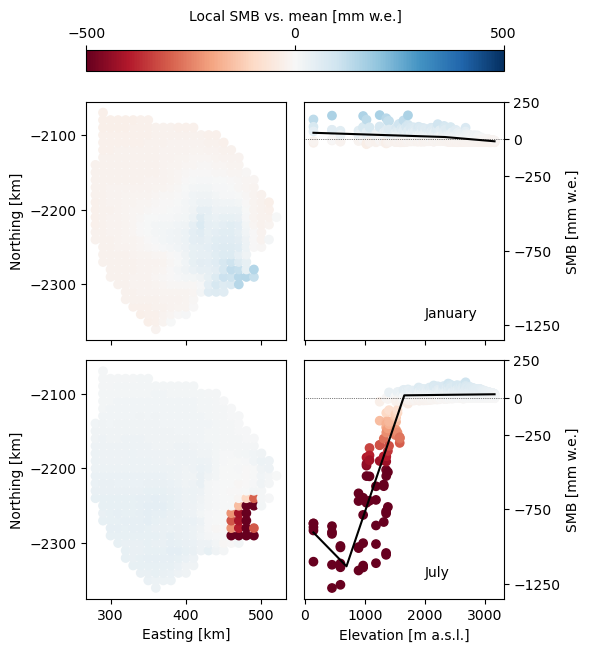

In [77]:
# fig2 = plt.figure(figsize=(6,10))
# grid = ImageGrid(fig1, 111, # similar to subplot(111)
#                  # nrows_ncols=(2,2),  # creates grid of axes
#                  axes_pad=0.2,  # pad between axes in inch.
#                  cbar_mode='edge', 
#                  cbar_set_cax=True
#                  )

month_numbers = (0,6) ## which two months to illustrate
month_labels = ('January', 'July')

fig, axs = plt.subplots(2, 2, sharex='col', sharey='col', 
                        figsize=(6,7), tight_layout=True)
for i, m in enumerate(month_numbers):
    ax1 = axs[i,0]
    ax2 = axs[i,1]
    
    ## maps
    # example_smb = example_df_per_ctchmnt[101]['ANICE-ITM_Berends'][m][1980]['point_smb']
    example_smb = example_df_per_ctchmnt[101]['RACMO_noel'][m][1980]['point_smb']
    sc = ax1.scatter(0.001*pt_ctmts[101][:,0], 0.001*pt_ctmts[101][:,1], 
               c=example_smb - np.mean(example_smb),
               vmin=-500, vmax=500,
               cmap='RdBu')
    ax1.set(xticks=(300,400,500), yticks=(-2100, -2200, -2300),
           ylabel='Northing [km]')
    
    ## lapse rate
    df = dict_per_month[m]
    pt_smbs = np.asarray(df.sort_values(by='elevation')['point_smb'])
    anomalies = pt_smbs - np.mean(pt_smbs)
    ax2.scatter(df.sort_values(by='elevation')['elevation'], anomalies, 
               c=anomalies, vmin=-500, vmax=500, cmap='RdBu',
               label=dates[m].strftime('%m/%Y'))

    px, py = monthly_mbg[m] ## call up what we already fit
    ax2.axhline(y=0, ls=':', lw=0.5, color='k')
    ax2.plot(px, py, color='k')
    ax2.text(2000,-1200,'{}'.format(month_labels[i]))
    ax2.set(xticks=(0,1000,2000,3000), 
            yticks=(-1250, -750, -250, 0, 250),
            ylabel='SMB [mm w.e.]'
           )
    ax2.yaxis.tick_right()
    ax2.yaxis.set_label_position('right')
    
    if i==1:
        ax1.set(xlabel='Easting [km]') ## only label the bottom one
        ax2.set(xlabel='Elevation [m a.s.l.]')
# plt.legend(loc='best')
plt.tight_layout()
cb = fig.colorbar(sc, ticks=(-500,0,500), ax=axs.ravel().tolist(), 
                  location='top', label='Local SMB vs. mean [mm w.e.]')
plt.savefig('/Users/lizz/Downloads/{}-Kanger_2month_LapseRateMap-RACMO.png'.format(datetime.date.today()),
            dpi=300)
plt.show()